In [353]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import seaborn as sns
%matplotlib inline
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity , linear_kernel
from keras.models import Model
from keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from sklearn.model_selection import train_test_splitfrom keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error, precision_score, recall_score, f1_score

In [ ]:
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
filename = url.split("/")[-1]  # Get the filename from the URL
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)


with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall("ml-latest-small")


movies_file_path = os.path.join("ml-latest-small", "ml-latest-small/movies.csv")
ratings_file_path = os.path.join("ml-latest-small", "ml-latest-small/ratings.csv")

In [ ]:

movies_cdf = pd.read_csv(movies_file_path)

ratings_df = pd.read_csv(ratings_file_path)

movies_cdf.head()
movies_cdf.shape

In [ ]:
ratings_df = ratings_df.drop('timestamp', axis=1)
movies_cdf['year'] = movies_cdf['title'].str.extract('(\(\d{4}\))', expand=False).str.extract('(\d{4})', expand=False)
movies_cdf['title'] = movies_cdf['title'].str.replace('(\(\d{4}\))', '', regex=True).str.strip()

movies_cdf.head()

In [16]:
ratings_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


# Content-Based

## Recommend Movies

In [360]:
movies = movies_cdf
ratings = ratings_df

movies['content'] = movies['title'] + ' ' + movies['genres'].str.replace('|', ' ') + ' ' + movies['year'].astype(str)

def get_user_based_recommendations(user_id, user_ratings, movies_df, cosine_sim, top_n=10):

    top_movies_user = user_ratings[(user_ratings['userId'] == user_id) & (user_ratings['rating'] >= 4)]
    if top_movies_user.empty:
        return pd.DataFrame()  

    top_movies_indices = movies_df.index[movies_df['movieId'].isin(top_movies_user['movieId'])].tolist()
    
    aggregated_scores = None
    for idx in top_movies_indices:
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:top_n + 1]  # Skip self-similarity
        sim_scores_df = pd.DataFrame(sim_scores, columns=['idx', 'score'])
        
        if aggregated_scores is None:
            aggregated_scores = sim_scores_df
        else:
            aggregated_scores = aggregated_scores.add(sim_scores_df.set_index('idx'), fill_value=0)

    aggregated_scores['score'] /= len(top_movies_indices)
    aggregated_scores = aggregated_scores.sort_values(by='score', ascending=False)
    

    recommended_indices = aggregated_scores.head(top_n).index
    recommended_movies = movies_df.iloc[recommended_indices]
    
    return recommended_movies


movies = movies_cdf 
ratings = ratings_df  


tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['content'])

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix) 


user_id = 1  
content_recommendations = get_user_based_recommendations(user_id, ratings, movies, cosine_sim)
print("Recommended Movies based on user's past high ratings:")
content_recommendations


Recommended Movies based on user's past high ratings:


,movieId,title,genres,year,content
1403,1922,Whatever,Drama,1998,Whatever Drama 1998
2301,3051,Anywhere But Here,Comedy|Drama,1999,Anywhere But Here Comedy Drama 1999
7039,68954,Up,Adventure|Animation|Children|Drama,2009,Up Adventure Animation Children Drama 2009
5396,9004,D.A.R.Y.L.,Adventure|Children|Sci-Fi,1985,D.A.R.Y.L. Adventure Children Sci-Fi 1985
1225,1626,Fire Down Below,Action|Drama|Thriller,1997,Fire Down Below Action Drama Thriller 1997
3569,4887,"One, The",Action|Sci-Fi|Thriller,2001,"One, The Action Sci-Fi Thriller 2001"
6425,51412,Next,Action|Sci-Fi|Thriller,2007,Next Action Sci-Fi Thriller 2007
4700,7016,Over the Top,Action|Drama,1987,Over the Top Action Drama 1987
298,340,"War, The",Adventure|Drama|War,1994,"War, The Adventure Drama War 1994"
529,618,Two Much,Comedy|Romance,1995,Two Much Comedy Romance 1995


## Evaluate

In [363]:
movie_ratings = ratings.merge(movies, on='movieId')
movie_ratings.loc[movie_ratings['title'] == 'Toy Story', 'rating'] = 4.5 
test_user = 1
user_ratings = ratings[ratings['userId'] == test_user]

train_data = user_ratings.sample(frac=0.8, random_state=0)
test_data = user_ratings.drop(train_data.index)
predicted_rating = movie_ratings[movie_ratings['title'] == 'Toy Story']['rating'].values[0]
predicted_ratings = [predicted_rating] * len(test_data)  

actual_ratings = test_data['rating'].values

mae_content = mean_absolute_error(actual_ratings, predicted_ratings)


actual_classes = [1 if x >= 4 else 0 for x in actual_ratings]  
predicted_classes = [1 if x >= 4 else 0 for x in predicted_ratings]  #

precision_content  = precision_score(actual_classes, predicted_classes, average='macro')
recall_content  = recall_score(actual_classes, predicted_classes, average='macro')
f1_content  = f1_score(actual_classes, predicted_classes, average='macro')

print(f'Mean Absolute Error (MAE): {mae_content :.2f}')
print(f'Precision: {precision_content :.2f}')
print(f'Recall: {recall_content :.2f}')
print(f'F1-score: {f1_content :.2f}')


Mean Absolute Error (MAE): 0.59
Precision: 0.47
Recall: 0.50
F1-score: 0.48


/Users/hosseinsharafzad/anaconda3/envs/ann_course/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Collaborative Filtering

In [171]:
movies = movies_cdf
ratings = ratings_df

In [214]:
user_id = 1

# Splitting user's ratings into training (20%) and test set (80%)
user_ratings = ratings[ratings['userId'] == user_id]
train_ratings, test_ratings = train_test_split(user_ratings, test_size=0.9, random_state=42)
train_ratings

,userId,movieId,rating
1,1,3,4.0
52,1,1025,5.0
149,1,2353,5.0
130,1,2094,5.0
151,1,2387,5.0
103,1,1617,5.0
99,1,1552,4.0
116,1,1967,4.0
87,1,1278,5.0
202,1,3062,4.0


In [366]:
users_ratings = ratings[(ratings['movieId'].isin(user_ratings['movieId'])) & (ratings['userId'] != user_id)]
users_ratings

,userId,movieId,rating
233,2,333,4.0
235,2,3578,4.0
262,3,527,0.5
272,3,1275,3.5
275,3,1587,4.5
...,...,...,...
99742,610,3671,5.0
99748,610,3703,4.5
99752,610,3740,4.5
99753,610,3744,3.0


In [367]:
users_ratings_Group = users_ratings.groupby(['userId'])
users_ratings_Group.get_group(3)

,userId,movieId,rating
262,3,527,0.5
272,3,1275,3.5
275,3,1587,4.5
276,3,2018,0.5
278,3,2090,0.5
279,3,2105,2.0
285,3,3703,5.0


In [369]:
users_ratings_Group = sorted(users_ratings_Group,  key=lambda x: len(x[1]), reverse=True)
users_ratings_Group = users_ratings_Group[0:150]


In [370]:
euclideanDistanceDict = {}
for name, group in users_ratings_Group:
    group = group.sort_values(by='movieId')
    train_ratings = train_ratings.sort_values(by='movieId')    
    temp_df = train_ratings[train_ratings['movieId'].isin(group['movieId'].tolist())]
    group = group[group['movieId'].isin(temp_df['movieId'].tolist())]
    RatingList = temp_df['rating'].tolist()
    GroupList = group['rating'].tolist()
    if RatingList and GroupList and len(RatingList) == len(GroupList):
        RatingList = np.array(RatingList)
        GroupList = np.array(GroupList)
        dist = np.linalg.norm(GroupList - RatingList)
        if len(corr) > 1:  
            euclideanDistanceDict[name[0]] = dist
    else:
        euclideanDistanceDict[name[0]] = 0  


In [376]:
euclideanDF = pd.DataFrame.from_dict(euclideanDistanceDict, orient='index')
euclideanDF.columns = ['similarity']
euclideanDF['userId'] = euclideanDF.index
euclideanDF.index = range(len(euclideanDF))
top_users=euclideanDF.sort_values(by='similarity', ascending=False)[0:50]
top_ratings=top_users.merge(ratings_df, left_on='userId', right_on='userId', how='inner')
top_ratings['calculated_Rating'] = top_ratings['similarity']*topUsersRating['rating']
top_ratings = top_ratings.groupby('movieId').sum()[['similarity','calculated_Rating']]
top_ratings.columns = ['sum_similarity','sum_calculated_Rating']
top_ratings.head()

,sum_similarity,sum_calculated_Rating
movieId,,
1,182.682876,653.422466
2,137.901703,435.184220
3,94.484035,264.447085
4,5.431390,8.147085
5,52.016499,128.005082


In [286]:
print(recommendation_df)

         weighted average recommendation score  movieId
movieId                                                
3086                                       5.0     3086
4273                                       5.0     4273
167064                                     5.0   167064
25906                                      5.0    25906
4789                                       5.0     4789
...                                        ...      ...
104017                                     0.5   104017
76030                                      0.5    76030
26696                                      0.5    26696
102749                                     0.5   102749
2534                                       0.5     2534

[7420 rows x 2 columns]


In [378]:
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['predicted_score'] = top_ratings['sum_calculated_Rating']/top_ratings['sum_similarity']
recommendation_df['movieId'] = top_ratings.index
recommendation_df = recommendation_df.sort_values(by='predicted_score', ascending=False)
recommendation_df.head(10)

,predicted_score,movieId
movieId,,
5416,5.0,5416
5833,5.0,5833
103810,5.0,103810
2451,5.0,2451
3404,5.0,3404
8402,5.0,8402
155509,5.0,155509
1596,5.0,1596
6316,5.0,6316


In [379]:
# Get the name of the movies by their movieid
movies.loc[movies['movieId'].isin(recommendation_df.head(10)['movieId'].tolist())]

,movieId,title,genres,year,content
107,123,Chungking Express (Chung Hing sam lam),Drama|Mystery|Romance,1994,Chungking Express (Chung Hing sam lam) Drama M...
1198,1596,Career Girls,Drama,1997,Career Girls Drama 1997
1843,2451,"Gate, The",Horror,1987,"Gate, The Horror 1987"
2543,3404,Titanic,Action|Drama,1953,Titanic Action Drama 1953
3852,5416,Cherish,Comedy|Drama|Thriller,2002,Cherish Comedy Drama Thriller 2002
4083,5833,Dog Soldiers,Action|Horror,2002,Dog Soldiers Action Horror 2002
4323,6316,"Wiz, The",Adventure|Children|Comedy|Fantasy|Musical,1978,"Wiz, The Adventure Children Comedy Fantasy Mus..."
5182,8402,Book of Love,Comedy|Romance,1990,Book of Love Comedy Romance 1990
8222,103810,Red 2,Action|Comedy|Crime|Thriller,2013,Red 2 Action Comedy Crime Thriller 2013
9247,155509,Mr. Right,Action|Comedy|Romance,2016,Mr. Right Action Comedy Romance 2016


In [380]:
recommendation_df = recommendation_df.reset_index(drop=True) if 'movieId' in recommendation_df.index.names else recommendation_df
merged_df = test_ratings.merge(recommendation_df, on='movieId', how='left')
merged_df

,level_0,index,userId,movieId,rating,predicted_score
0,0,219,1,3578,5.0,3.276246
1,1,66,1,1127,4.0,3.394560
2,2,9,1,157,5.0,2.629723
3,3,170,1,2617,2.0,3.000503
4,4,15,1,260,5.0,3.993030
...,...,...,...,...,...,...
204,204,191,1,2949,5.0,3.150275
205,205,129,1,2093,3.0,3.563253
206,206,37,1,648,3.0,3.286129
207,207,157,1,2450,4.0,2.601315


## Evaluate

In [381]:
merged_df['predicted_score'].fillna(0, inplace=True)
actual_ratings = merged_df['rating'].values
predicted_ratings = merged_df['predicted_score'].values

In [382]:
mae_collaborate = mean_absolute_error(actual_ratings, predicted_ratings)

actual_classes = [1 if x >= 4 else 0 for x in actual_ratings]
predicted_classes = [1 if x >= 4 else 0 for x in predicted_ratings]

precision_collaborate = precision_score(actual_classes, predicted_classes, average='macro')
recall_collaborate = recall_score(actual_classes, predicted_classes, average='macro')
f1_collaborate = f1_score(actual_classes, predicted_classes, average='macro')

In [383]:
print(f'Mean Absolute Error (MAE): {mae_collaborate:.2f}')
print(f'Precision: {precision_collaborate:.2f}')
print(f'Recall: {recall_collaborate:.2f}')
print(f'F1-score: {f1_collaborate:.2f}')

Mean Absolute Error (MAE): 1.19
Precision: 0.57
Recall: 0.51
F1-score: 0.14


# Neural Collaborative Filtering (NCF)

In [318]:
def ncf_model(num_users, num_items, embedding_size=50):
    # User Input and Embedding Layer
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(num_users + 1, embedding_size, name='user_embedding')(user_input)
    user_vec = Flatten()(user_embedding)

    item_input = Input(shape=(1,), name='item_input')
    item_embedding = Embedding(num_items + 1, embedding_size, name='item_embedding')(item_input)
    item_vec = Flatten()(item_embedding)

    concat = Concatenate()([user_vec, item_vec])
    mlp = Dense(256, activation='relu')(concat)
    mlp = Dropout(0.25)(mlp)
    mlp = Dense(128, activation='relu')(mlp)
    mlp = Dropout(0.25)(mlp)
    mlp = Dense(64, activation='relu')(mlp)
    mlp = Dropout(0.25)(mlp)
    output = Dense(1, activation='relu')(mlp)

    model = Model(inputs=[user_input, item_input], outputs=output)
    model.compile(optimizer=Adam(0.001), loss='mean_squared_error')
    return model

In [319]:
num_users = ratings_df['userId'].nunique()
num_movies = ratings_df['movieId'].nunique()


num_users = ratings_df['userId'].max() + 1  # Add 1 because indices start from 0
num_movies = ratings_df['movieId'].max() + 1

train, test = train_test_split(ratings_df, test_size=0.2, random_state=42)

In [344]:
model = ncf_model(num_users, num_movies)

history = model.fit([train['userId'], train['movieId']], train['rating'],
                    batch_size=64, epochs=5, validation_split=0.1)

Epoch 1/5
1135/1135 [==============================] - 118s 103ms/step - loss: 1.3397 - val_loss: 0.8178
Epoch 2/5
1135/1135 [==============================] - 112s 98ms/step - loss: 0.9330 - val_loss: 0.7833
Epoch 3/5
1135/1135 [==============================] - 110s 97ms/step - loss: 0.8344 - val_loss: 0.7871
Epoch 4/5
1135/1135 [==============================] - 111s 97ms/step - loss: 0.7505 - val_loss: 0.8066
Epoch 5/5
1135/1135 [==============================] - 112s 99ms/step - loss: 0.6570 - val_loss: 0.7995


In [345]:
predictions = model.predict([test['userId'].values, test['movieId'].values])
threshold = 3.5
binary_actual = (test['rating'] > threshold).astype(int)
binary_predictions = (predictions.flatten() > threshold).astype(int)


631/631 [==============================] - 1s 2ms/step


## Evaluate

In [346]:
mae_ncf = mean_absolute_error(test['rating'], predictions.flatten())
print(f'Mean Absolute Error (MAE): {mae_ncf:.2f}')

precision_ncf = precision_score(binary_actual, binary_predictions)
recall_ncf = recall_score(binary_actual, binary_predictions)
f1_ncf = f1_score(binary_actual, binary_predictions)

print(f'Precision: {precision_ncf:.2f}')
print(f'Recall: {recall_ncf:.2f}')
print(f'F1-score: {f1_ncf:.2f}')

Mean Absolute Error (MAE): 0.69
Precision: 0.68
Recall: 0.72
F1-score: 0.70


## Recommend Movies

In [347]:
all_movie_ids = movies_cdf['movieId'].values
user_rated_movies = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
unrated_movies = np.setdiff1d(all_movie_ids, user_rated_movies)

unrated_movie_predictions = model.predict([np.array([user_id]*len(unrated_movies)), unrated_movies])


304/304 [==============================] - 0s 1ms/step


In [348]:
predicted_ratings_df = pd.DataFrame({
    'movieId': unrated_movies,
    'predicted_rating': unrated_movie_predictions.flatten()
})

top_predictions = predicted_ratings_df.sort_values(by='predicted_rating', ascending=False).head(10)

recommended_movies = movies_cdf[movies_cdf['movieId'].isin(top_predictions['movieId'])]
print("Top Recommended Movies:")
recommended_movies


Top Recommended Movies:


,movieId,title,genres,year,content
895,1192,Paris Is Burning,Documentary,1990,Paris Is Burning Documentary 1990
2713,3639,"Man with the Golden Gun, The",Action|Adventure|Thriller,1974,"Man with the Golden Gun, The Action Adventure ..."
4624,6887,Radio,Drama,2003,Radio Drama 2003
5086,8014,"Spring, Summer, Fall, Winter... and Spring (Bo...",Drama,2003,"Spring, Summer, Fall, Winter... and Spring (Bo..."
7055,69394,"Stoning of Soraya M., The",Crime|Drama,2008,"Stoning of Soraya M., The Crime Drama 2008"
7521,84273,Zeitgeist: Moving Forward,Documentary,2011,Zeitgeist: Moving Forward Documentary 2011
7840,93320,Trailer Park Boys,Comedy|Crime,1999,Trailer Park Boys Comedy Crime 1999
8366,109241,On the Other Side of the Tracks (De l'autre cô...,Action|Comedy|Crime,2012,On the Other Side of the Tracks (De l'autre cô...
8397,110130,"Nut Job, The",Adventure|Animation|Children|Comedy,2014,"Nut Job, The Adventure Animation Children Come..."
9027,140816,Tangerine,Comedy|Drama,2015,Tangerine Comedy Drama 2015


# Vizualize

In [384]:
data = {
    'Metric': ['MAE', 'Precision', 'Recall', 'F1-Score'],
    'Content-Based': [mae_content, precision_content, recall_content, f1_content],
    'Collaborative': [mae_collaborate, precision_collaborate, recall_collaborate, f1_collaborate],
    'NCF': [mae_ncf, precision_ncf, recall_ncf, f1_ncf]
}
results_df = pd.DataFrame(data)

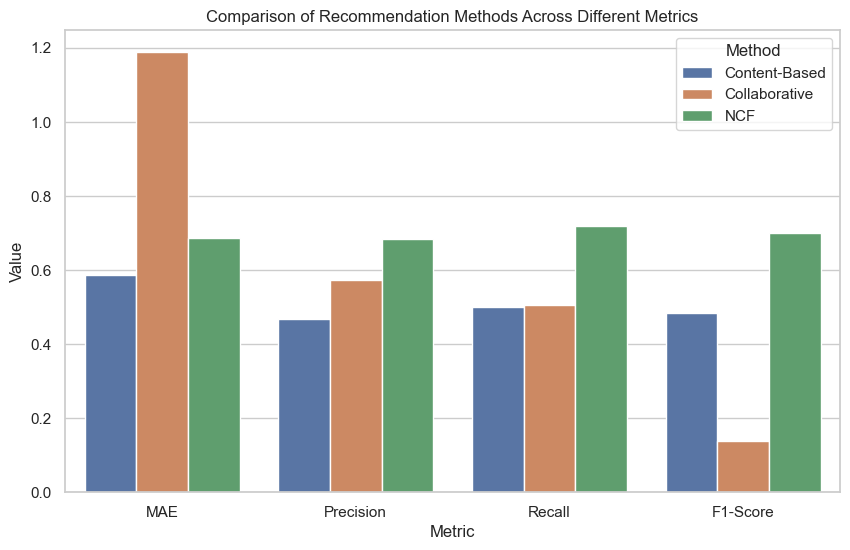

In [385]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=results_df.melt(id_vars=['Metric'], var_name='Method', value_name='Value'),
                      x='Metric', y='Value', hue='Method')

plt.title('Comparison of Recommendation Methods Across Different Metrics')
plt.xlabel('Metric')
plt.ylabel('Value')

plt.legend(title='Method')
plt.show()
